# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [2]:
def get_rid_of_str(x):
    L = []
    for i in x:
        try:
                y =int(i)
        except:
                y=i
        L.append(y)
    return(L)

In [3]:
# function to remove items of B from A and return A
# li-B list of items to be removes
# li_A main list to be cleaned up
def clean_list(li_B, li_A):
    for k in li_B:
        for j in li_A:
                if k == j:
                        li_A.remove(k)
    return(li_A)

    
    

In [4]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components

    INPUT: pca - the result of instantian of PCA in scikit learn

    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_

    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')



In [5]:
def pca_results(full_dataset, pca):
        '''
        Create a DataFrame of the PCA results
        Includes dimension feature weights and explained variance
        Visualizes the PCA results
        '''

        # Dimension indexing
        dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

        # PCA components
        components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
        components.index = dimensions

        # PCA explained variance
        ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
        variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
        variance_ratios.index = dimensions

        # Create a bar plot visualization
        fig, ax = plt.subplots(figsize = (14,8))

        # Plot the feature weights as a function of the components
        components.plot(ax = ax, kind = 'bar');
        ax.set_ylabel("Feature Weights")
        ax.set_xticklabels(dimensions, rotation=0)


        # Display the explained variance ratios
        for i, ev in enumerate(pca.explained_variance_ratio_):
                ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

        # Return a concatenated DataFrame
        return pd.concat([variance_ratios, components], axis = 1)


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [6]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep =';')

In [7]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep =';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep =';')

In [8]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(' azdias contains ',len(azdias),' records')
print(' azdias contains ',len(azdias.columns),' columns')


 azdias contains  891221  records
 azdias contains  85  columns


In [9]:
# Creates a list containing 85 lists, each of 5 items, all set to a value that never occurs in the dataframe
w = 85
h = 5
X = [[7988888 for x in range(h)] for y in range(w)]
#

In [10]:
l = len(feat_info)
for i in range (0,l):
    feat_info.loc[i,'missing_or_unknown'] = feat_info.loc[i,'missing_or_unknown'].strip('[]').split(',')
    for elem in range(len(feat_info.loc[i,'missing_or_unknown'])):
        try:
            X[i][elem] = int(feat_info.loc[i,'missing_or_unknown'][elem])
        except:
            X[i][elem] = feat_info.loc[i,'missing_or_unknown'][elem]
                                



> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
#
start = time.time()
for j in range(0,85):
      for k in range (0,len(X[j])):
            azdias.iloc[:,j][azdias.iloc[:,j]==X[j][k]]=np.nan
end = time.time()
print("Total execution time of this procedure: {:.2f} seconds".format(end-start))

C:\Users\joepareti54\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\joepareti54\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Total execution time of this procedure: 6.08 seconds


In [12]:
#inspect a subset of the updated dataframe
ss = azdias[['AGER_TYP','PLZ8_ANTG1', 'PLZ8_ANTG2','PLZ8_ANTG4', 'PRAEGENDE_JUGENDJAHRE', 'GEBURTSJAHR']]
print(ss.head())
#

   AGER_TYP  PLZ8_ANTG1  PLZ8_ANTG2  PLZ8_ANTG4  PRAEGENDE_JUGENDJAHRE  \
0       NaN         NaN         NaN         NaN                    NaN   
1       NaN         2.0         3.0         1.0                   14.0   
2       NaN         3.0         3.0         0.0                   15.0   
3       2.0         2.0         2.0         0.0                    8.0   
4       NaN         2.0         4.0         1.0                    8.0   

   GEBURTSJAHR  
0          NaN  
1       1996.0  
2       1979.0  
3       1957.0  
4       1963.0  


In [13]:
#save the transformed azdias dataframe to a csv file
#https://datatofish.com/export-dataframe-to-csv/
#
#azdias.to_csv (r'F:\x\finance-2019\AI/udacity\ML_introduction\IdentifyCustomerSegments\workspace\azdias_tf_JP3.csv', header=True)
#print(azdias)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

col  0  col-label  AGER_TYP  number of NaN  685843  % of Nan  76.95543529607134
col  11  col-label  GEBURTSJAHR  number of NaN  392318  % of Nan  44.02028228688507
col  40  col-label  TITEL_KZ  number of NaN  889061  % of Nan  99.75763587258379
col  43  col-label  ALTER_HH  number of NaN  310267  % of Nan  34.81369940789097
col  47  col-label  KK_KUNDENTYP  number of NaN  584612  % of Nan  65.59674873011296
col  64  col-label  KBA05_BAUMAX  number of NaN  476524  % of Nan  53.468668265222654


Text(0, 0.5, '%NaN in column')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


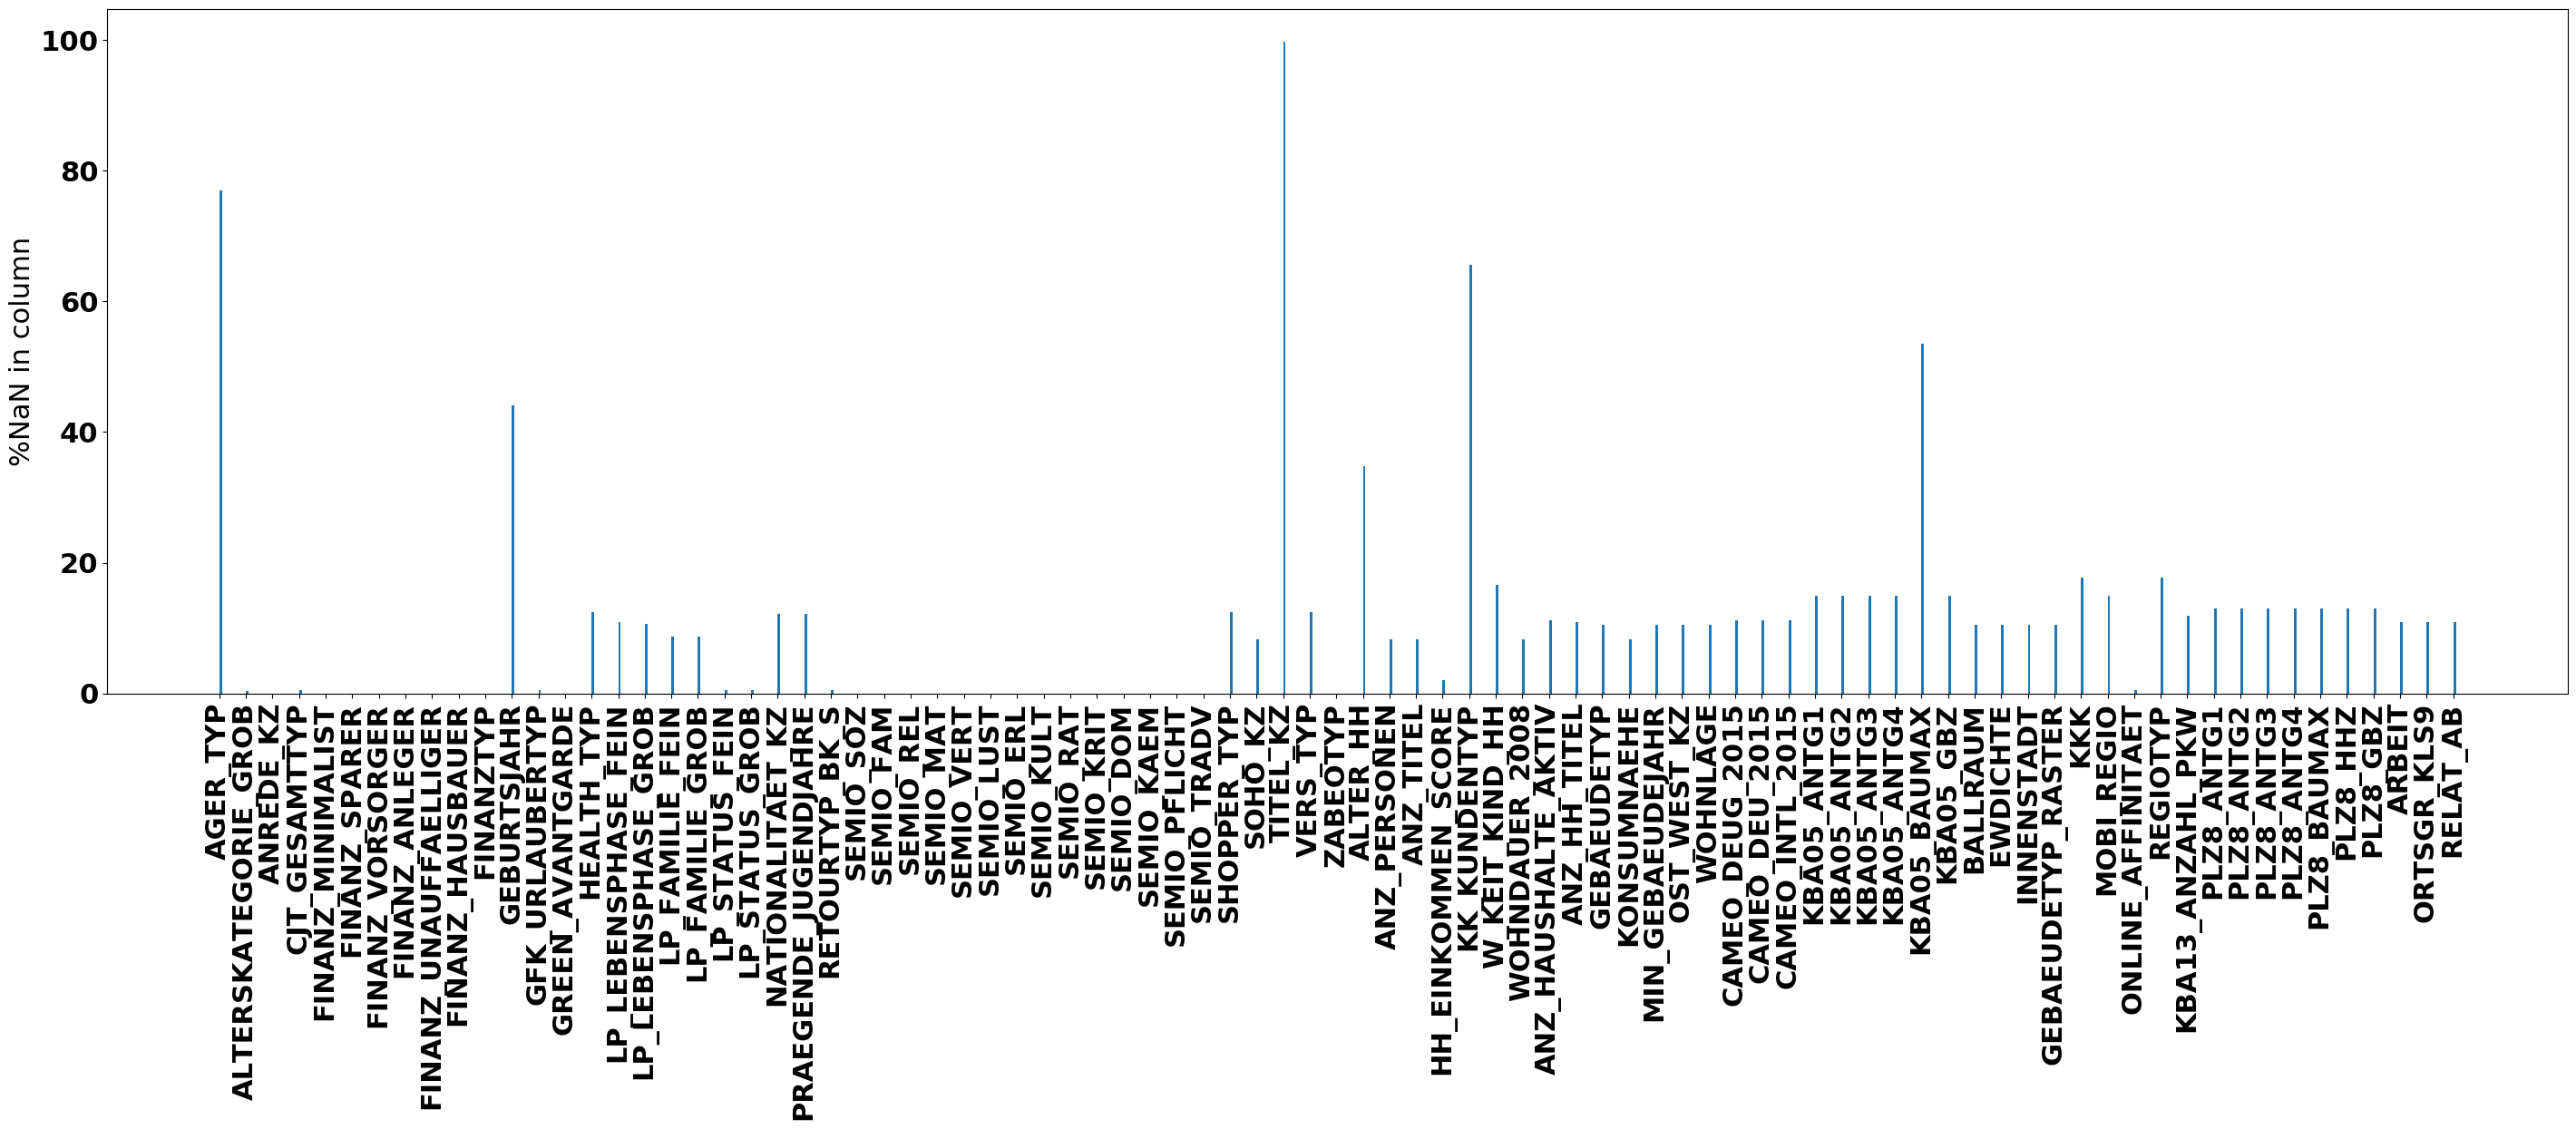

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
from matplotlib.pyplot import figure
figure(num=None, figsize=(35, 10), dpi=100, facecolor='w', edgecolor='k')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
l = len(azdias.columns)
Y = [0 for y in range(l)]
XX = [i for i in range(0,l)]
COL_LABEL = azdias.columns
m = len(azdias)

for i in range(0,l):
    n_nan = azdias.iloc[:,i].isna().sum()
    prop = n_nan*100/m
    Y[i]=prop
    if prop > 20:
        print('col ',i,' col-label ',COL_LABEL[i],' number of NaN ',n_nan,' % of Nan ',n_nan*100/m)
    

plt.xticks(ticks=XX,labels=azdias.columns,rotation='vertical')
plt.bar(XX,Y,align='edge',width =0.1)
plt.ylabel('%NaN in column')

In [15]:
# Investigate patterns in the amount of missing data in each column.



In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_MASTER = azdias.copy()
azdias=azdias_MASTER.drop(columns=['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX' ])
print(len(azdias.columns))
print(len(azdias_MASTER.columns))

79
85


#### Discussion 1.1.2: Assess Missing Data in Each Column
The number of NaN per column has been calculated, and there are 6 columns with >20% NaN. I used a bar chart to identify which columns have the most NaN values, and dropped those columns. Those are: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX' ] Presumably the model accuracy will not suffer much because the information can be retrieved from other features in the dataset.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

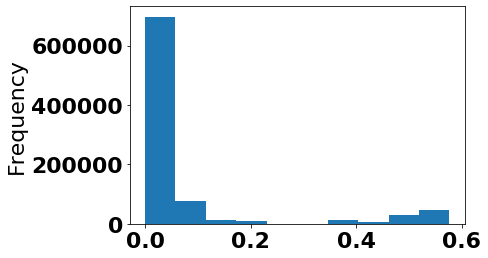

In [17]:
# How much data is missing in each row of the dataset?
azdias['number_nan'] = azdias.isna().sum(axis=1)
azdias['pct_nan'] = azdias['number_nan']/l
azdias['pct_nan'].plot(kind='hist', bins=10)



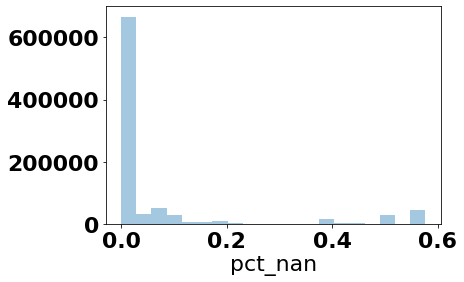

In [18]:
# How much data is missing in each row of the dataset? (continued)
import seaborn as sns
sns.distplot(azdias['pct_nan'],kde=False, bins=20)

In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# use https://www.shanelynn.ie/using-pandas-dataframe-creating-editing-viewing-data-in-python/

above = 0.2
azdias_outliers = azdias[azdias['pct_nan'] > above]
azdias_normal = azdias[azdias['pct_nan'] < above]
#
print('size of outliers dataframe ',len(azdias_outliers))
print('size of retained dataframe -row-wise ',len(azdias_normal))

size of outliers dataframe  95752
size of retained dataframe -row-wise  794792


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


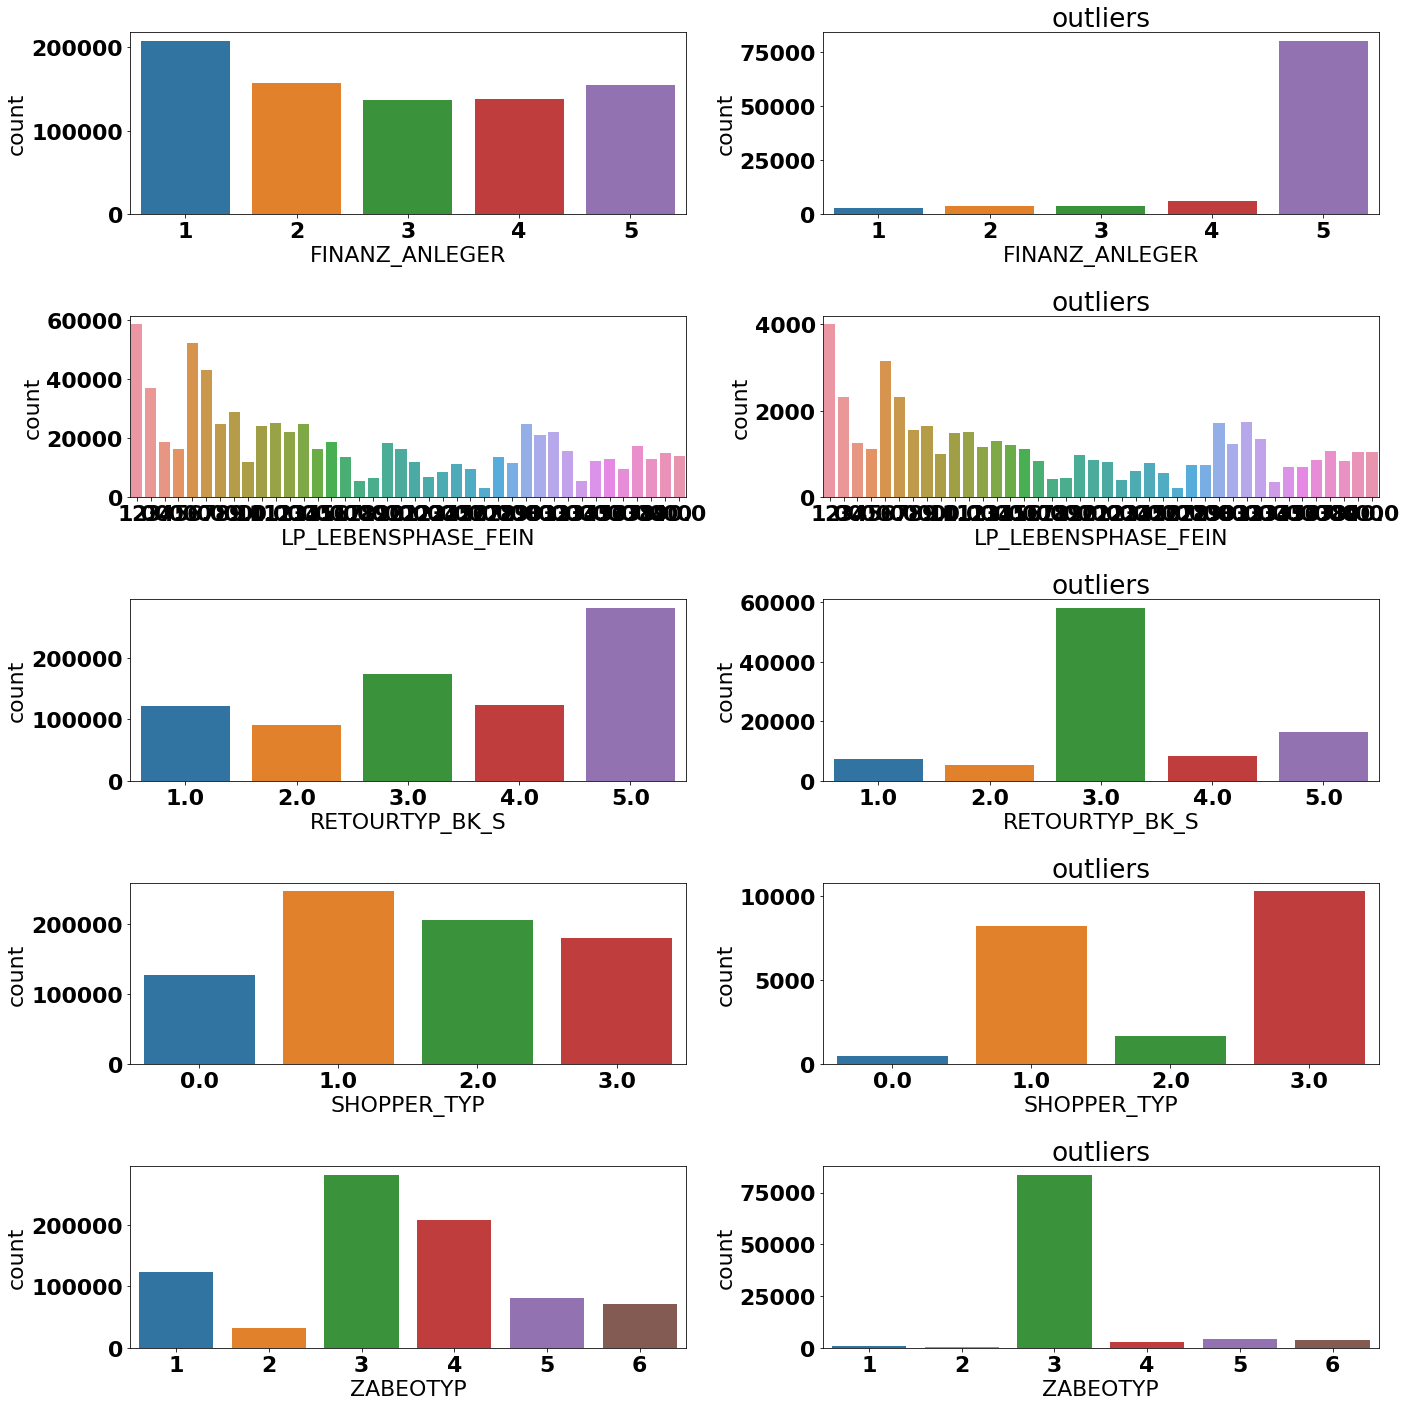

In [20]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
fig, AX =plt.subplots(5,2, figsize=(20,20))
sns.countplot(azdias_normal['FINANZ_ANLEGER'], ax=AX[0,0])
sns.countplot(azdias_outliers['FINANZ_ANLEGER'], ax=AX[0,1])
AX[0,1].set_title('outliers')
sns.countplot(azdias_normal['LP_LEBENSPHASE_FEIN'], ax=AX[1,0])
sns.countplot(azdias_outliers['LP_LEBENSPHASE_FEIN'], ax=AX[1,1])
AX[1,1].set_title('outliers')
sns.countplot(azdias_normal['RETOURTYP_BK_S'], ax=AX[2,0])
sns.countplot(azdias_outliers['RETOURTYP_BK_S'], ax=AX[2,1])
AX[2,1].set_title('outliers')
sns.countplot(azdias_normal['SHOPPER_TYP'], ax=AX[3,0])
sns.countplot(azdias_outliers['SHOPPER_TYP'], ax=AX[3,1])
AX[3,1].set_title('outliers')
sns.countplot(azdias_normal['ZABEOTYP'], ax=AX[4,0])
sns.countplot(azdias_outliers['ZABEOTYP'], ax=AX[4,1])
AX[4,1].set_title('outliers')
plt.tight_layout()



#### Discussion 1.1.3: Assess Missing Data in Each Row

The histogram with x-axis = 'pct_NaN' suggests that roughly 20% of the rows of the AZDIAS dataframe contain the largest proportion of NaN values. Hence, I split up the dataframe into a ‘normal’ dataframe and an ‘outlier’ one, where the outlier data segment is defined as having 20% or more NaN values.
The values distribution across the ‘normal’ and ‘outliers’ dataset on 5 arbitrarily chosen columns significantly differs. For this project, the outliers dataframe is ignored. The choice of columns might be refined at the end of the analysis to evaluate the distributions for those columns that impact most the decision making.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [21]:
# How many features are there of each data type?
#print(feat_info)
li = feat_info['type'].unique()
print(li)
#li = ['categorical', 'ordinal', 'mixed', 'numeric']
for k in li:
    a= len(feat_info[feat_info['type']==k])
    print('feature ',k,' count ',a)


['categorical' 'ordinal' 'numeric' 'mixed' 'interval']
feature  categorical  count  21
feature  ordinal  count  49
feature  numeric  count  7
feature  mixed  count  7
feature  interval  count  1


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
li_B=['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX' ]
li_c  = feat_info['attribute'][feat_info['type']=='categorical'].values.tolist()
for k in li_B:
    for j in li_c:
        if k == j:
            li_c.remove(k)
print('list of categorical features to be processed')
print(li_c)
print('----------------------')
#['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX' ]
print(li_c)
for k in li_c:
    s = azdias.loc[:,k]
    if len(s.dropna().unique()) == 2:
        print('feature ',k,' is binary ')
    else:
        print('feature ',k,'is multilevel= ',len(s.dropna().unique()))

                  


list of categorical features to be processed
['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
----------------------
['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
feature  ANREDE_KZ  is binary 
feature  CJT_GESAMTTYP is multilevel=  6
feature  FINANZTYP is multilevel=  6
feature  GFK_URLAUBERTYP is multilevel=  12
feature  GREEN_AVANTGARDE  is binary 
feature  LP_FAMILIE_FEIN is multilevel=  11
feature  LP_FAMILIE_GROB is multilevel=  5
feature  LP_STATUS_FEIN is multilevel=  10
feature  LP_STATUS_GROB

In [23]:
# get rid of CAMEO_DEU_2015 --> too many variables
# get rid of auxiliary columns 'number_nan' and 'pct_nan'
azdias_normal.drop(columns=['CAMEO_DEU_2015', 'number_nan', 'pct_nan'], inplace=True)
li_c.remove('CAMEO_DEU_2015')
print(li_c)


['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015']


C:\Users\joepareti54\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [24]:
# Re-encode categorical variable(s) to be kept in the analysis
# deal with OST_WEST_K feature first

azdias_normal.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True);

C:\Users\joepareti54\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [25]:
#re-assess
for k in li_c:
    s = azdias.loc[:,k]
    if len(s.dropna().unique()) == 2:
        print('feature ',k,' is binary ')
    else:
        print('feature ',k,'is multilevel= ',len(s.dropna().unique()))

feature  ANREDE_KZ  is binary 
feature  CJT_GESAMTTYP is multilevel=  6
feature  FINANZTYP is multilevel=  6
feature  GFK_URLAUBERTYP is multilevel=  12
feature  GREEN_AVANTGARDE  is binary 
feature  LP_FAMILIE_FEIN is multilevel=  11
feature  LP_FAMILIE_GROB is multilevel=  5
feature  LP_STATUS_FEIN is multilevel=  10
feature  LP_STATUS_GROB is multilevel=  5
feature  NATIONALITAET_KZ is multilevel=  3
feature  SHOPPER_TYP is multilevel=  4
feature  SOHO_KZ  is binary 
feature  VERS_TYP  is binary 
feature  ZABEOTYP is multilevel=  6
feature  GEBAEUDETYP is multilevel=  7
feature  OST_WEST_KZ  is binary 
feature  CAMEO_DEUG_2015 is multilevel=  9


In [26]:
cols0 = azdias_normal.columns.tolist()
print(cols0)

['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDIC

In [27]:
# 1-hot-encode other categorical features
start = time.time()
for item in li_c:
    d = pd.get_dummies(azdias_normal[item], prefix=item)
    azdias_normal = azdias_normal.drop(item, axis=1).join(d)
end = time.time()
print("Total execution time of this procedure: {:.2f} seconds".format(end-start))

Total execution time of this procedure: 16.88 seconds


In [28]:
#sanity check #1: how many columns after transformation
print('number of columns after transformations ', len(azdias_normal.columns))
# remove outliers and CAMEO_DEU_2015
n0 = 85 - len(li_B) - 1
#
n1 = 0
# multivariate categorical features, each expaning to len(s.dropna().unique()) new cols - 1
for k in li_c:
    s = azdias.loc[:,k]
    n1 = n1 + len(s.dropna().unique()) -1
n_cols_after_enc_ShouldBe = n0+ n1
print('expected number of columns after transformations ',n_cols_after_enc_ShouldBe )
print(azdias_normal.columns)

number of columns after transformations  155
expected number of columns after transformations  155
Index(['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
       'LP_LEBENSPHASE_GROB',
       ...
       'OST_WEST_KZ_1', 'CAMEO_DEUG_2015_1', 'CAMEO_DEUG_2015_2',
       'CAMEO_DEUG_2015_3', 'CAMEO_DEUG_2015_4', 'CAMEO_DEUG_2015_5',
       'CAMEO_DEUG_2015_6', 'CAMEO_DEUG_2015_7', 'CAMEO_DEUG_2015_8',
       'CAMEO_DEUG_2015_9'],
      dtype='object', length=155)


In [29]:
#cols = azdias_normal.columns.tolist()
#print(cols)

#### Discussion 1.2.1: Re-Encode Categorical Features

The OST_WEST_KZ feature has been transformed into a numerical binary feature. O: East (GDR) has value= 1; W: West (FRG) has value =0.

I have created dummies for all categorical variables, including the binary ones and dropped ‘CAMEO_DEU_2015’ that would have resulted in 44 dummies.
 



#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [30]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#create binary variable STREAM 0:mainstream 1:avantgarde
stream_0 = [1, 3, 5, 8, 10, 12, 14]
stream_1 = [2, 4, 6, 7, 9, 11, 13, 15]
# convert PRAEGENDE_JUGENDJAHRE to list_0
list_0 = azdias_normal['PRAEGENDE_JUGENDJAHRE'].values.tolist()
# create a list of length = len(customer) whose elements are:
#  0 if the value of 'PRAEGENDE_JUGENDJAHRE' is in stream_0
#  1 if the value of 'PRAEGENDE_JUGENDJAHRE' is in stream_1
L = []
for i in list_0:
    if i in stream_0:
        L.append(0)
    elif i in stream_1:
        L.append(1)
    else:
        L.append(i)
# convert the list to a new column of customer df
azdias_normal['PRAEGENDE_JUGENDJAHRE_STREAM'] = L




In [31]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#create variable DECADE:
#create a list of length = len(customer) whose elements are:
#40 if the value of 'PRAEGENDE_JUGENDJAHRE' is 1 or 2
#50 if the value of 'PRAEGENDE_JUGENDJAHRE' is 3 or 4
#60 if the value of 'PRAEGENDE_JUGENDJAHRE' is 5 or 6 or 7
#70 if the value of 'PRAEGENDE_JUGENDJAHRE' is 8 or 9
#80 if the value of 'PRAEGENDE_JUGENDJAHRE' is 10 or 11 or 12 or 13
#90 if the value of 'PRAEGENDE_JUGENDJAHRE' is 14 or 15
L=[]
print(list_0)
for i in list_0:
    if i == 1 or i == 2:
        L.append(40)
    elif i == 3 or i == 4:
        L.append(50)
    elif i == 5 or i == 6 or i == 7:
        L.append(60)
    elif i == 8 or i == 9:
        L.append(70)
    elif i == 10 or i == 11 or i == 12 or i == 13:
        L.append(80)
    elif i == 14 or i ==15:
        L.append(90)
    else:
        L.append(i)
azdias_normal['PRAEGENDE_JUGENDJAHRE_DECADE'] =  L
# drop PRAEGENDE_JUGENDJAHRE column
#azdias_normal.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [32]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# deal with str and NaN in input
list_0 = azdias_normal['CAMEO_INTL_2015'].values.tolist()
list_1 = get_rid_of_str(list_0)
azdias_normal.drop(columns=['CAMEO_INTL_2015'], inplace=True)
azdias_normal['CAMEO_INTL_2015']=list_1


In [33]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
import math
azdias_normal['CAMEO_INTL_2015_WEALTH'] = azdias_normal['CAMEO_INTL_2015'].apply(lambda x: x if math.isnan(x) else int(x/10))
azdias_normal['CAMEO_INTL_2015_LIFE'] = azdias_normal['CAMEO_INTL_2015'].apply(lambda x: x if math.isnan(x) else int(x%10))
#azdias_normal.drop(columns=['CAMEO_INTL_2015'], inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

The following mixed features have been transformed:

1.	PRAEGENDE_JUGENDJAHRE
  a.	New feature: PRAEGENDE_JUGENDJAHRE_DECADE having values equaling the           decade depending on the code in Data_Dictionary.md
  b.    New feature: PRAEGENDE_JUGENDJAHRE_STREAM; 0 means mainstream, 1  means         avantgarde
2.	CAMEO_INTL_2015
  a.	CAMEO_INTL_2015_WEALTH having values equaling the tens-place digit, so         that 1 means high income and 5 means low income 
  b.	CAMEO_INTL_2015_LIFE having values equaling the ones place digit,               meaning that 1 corresponds to young and 5 corresponds to old
        
After completion of the above transformations, all original, mixed features      columns have been dropped.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [34]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
# identify mixed features
li_mixed = feat_info['attribute'][feat_info['type']=='mixed'].values.tolist()
li_mixed_F = clean_list(li_B, li_mixed)
azdias_normal.drop(columns=li_mixed_F, inplace=True)




In [35]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
# sanity check #2 on number of columns
#
print('number of columns after all transformations ', len(azdias_normal.columns))
# -len(li_mixed) --> remove mixed
# +2 --> 2 cols resulting from PRAEGENDE_JUGENDJAHRE
# +2 --> 2 cols resulting from CAMEO_INTL_2015
n_cols_final = n_cols_after_enc_ShouldBe - len(li_mixed) + 2 + 2
print('expected number of columns', n_cols_final)


number of columns after all transformations  153
expected number of columns 153


In [36]:
#azdias_normal.to_csv (r'F:\x\finance-2019\AI/udacity\ML_introduction\IdentifyCustomerSegments\workspace\azdias_normal_may14.csv', header=True)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [37]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    
    # remove selected columns and rows, ...

    
    # select, re-encode, and engineer column values.

    
    # Return the cleaned dataframe.
    
    

In [38]:
def process_dataframe(DATAFRAME):
# Load in the feature summary file.
        feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep =';')
        print(' DATAFRAME contains ',len(DATAFRAME),' records')
        print(' DATAFRAME contains ',len(DATAFRAME.columns),' columns')
# Creates a list containing 85 lists, each of 5 items, all set to a value that never occurs in the dataframe
        w = 85
        h = 5
        X = [[7988888 for x in range(h)] for y in range(w)]
#
        l = len(feat_info)
        for i in range (0,l):
                feat_info.loc[i,'missing_or_unknown'] = feat_info.loc[i,'missing_or_unknown'].strip('[]').split(',')
                for elem in range(len(feat_info.loc[i,'missing_or_unknown'])):
                        try:
                                X[i][elem] = int(feat_info.loc[i,'missing_or_unknown'][elem])
                        except:
                                X[i][elem] = feat_info.loc[i,'missing_or_unknown'][elem]
        start = time.time()
        for j in range(0,85):
                for k in range (0,len(X[j])):
                        DATAFRAME.iloc[:,j][DATAFRAME.iloc[:,j]==X[j][k]]=np.nan
        end = time.time()
        print("Total execution time for converting unknown values to NaN ", (end-start), 'seconds')
# Perform an assessment of how much missing data there is in each column of the
# dataset.
        l = len(DATAFRAME.columns)
        Y = [0 for y in range(l)]
        XX = [i for i in range(0,l)]
        COL_LABEL = DATAFRAME.columns
        m = len(DATAFRAME)

        for i in range(0,l):
                n_nan = DATAFRAME.iloc[:,i].isna().sum()
                prop = n_nan*100/m
                Y[i]=prop
                if prop > 20:
                        print('col ',i,' col-label ',COL_LABEL[i],' number of NaN ',n_nan,' % of Nan ',n_nan*100/m)
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
        DATAFRAME_MASTER = DATAFRAME.copy()
        DATAFRAME=DATAFRAME_MASTER.drop(columns=['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX' ])
        print(len(DATAFRAME.columns))
        print(len(DATAFRAME_MASTER.columns))
# How much data is missing in each row of the dataset?
        DATAFRAME['number_nan'] = DATAFRAME.isna().sum(axis=1)
        DATAFRAME['pct_nan'] = DATAFRAME['number_nan']/l
# divide the data into two subsets based on the number of missing values in each row
        above = 0.2
        DATAFRAME_outliers = DATAFRAME[DATAFRAME['pct_nan'] > above]
        DATAFRAME_normal = DATAFRAME[DATAFRAME['pct_nan'] < above]
#
        print('size of outliers dataframe ',len(DATAFRAME_outliers))
        print('size of retained dataframe -row-wise ',len(DATAFRAME_normal))
# How many features are there of each data type?
        li = feat_info['type'].unique()
        print(li)
        for k in li:
                a= len(feat_info[feat_info['type']==k])
                print('feature ',k,' count ',a)
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
        li_B=['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX' ]
        li_c  = feat_info['attribute'][feat_info['type']=='categorical'].values.tolist()
        for k in li_B:
                for j in li_c:
                        if k == j:
                                li_c.remove(k)
        print('list of categorical features to be processed')
        print(li_c)
        print('----------------------')
#['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX' ]
        print(li_c)
        for k in li_c:
                s = DATAFRAME.loc[:,k]
                if len(s.dropna().unique()) == 2:
                        print('feature ',k,' is binary ')
                else:
                        print('feature ',k,'is multilevel= ',len(s.dropna().unique()))
# get rid of CAMEO_DEU_2015 --> too many variables
# get rid of auxiliary columns 'number_nan' and 'pct_nan'
        DATAFRAME_normal.drop(columns=['CAMEO_DEU_2015', 'number_nan', 'pct_nan'], inplace=True)
        li_c.remove('CAMEO_DEU_2015')
        print(li_c)
# Re-encode categorical variable(s) to be kept in the analysis
# deal with OST_WEST_K feature first
        DATAFRAME_normal.loc[:, 'OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True);
#re-assess
        for k in li_c:
                s = DATAFRAME.loc[:,k]
                if len(s.dropna().unique()) == 2:
                        print('feature ',k,' is binary ')
                else:
                        print('feature ',k,'is multilevel= ',len(s.dropna().unique()))
# 1-hot-encode other categorical features
        start = time.time()
        for item in li_c:
                d = pd.get_dummies(DATAFRAME_normal[item], prefix=item)
                DATAFRAME_normal = DATAFRAME_normal.drop(item, axis=1).join(d)
        end = time.time()
        print('exec time for 1-hot-encoding of categorical variables ',(end-start),' seconds')
#sanity check #1: how many columns after transformation
        print('number of columns after transformations ', len(DATAFRAME_normal.columns))
# remove outliers and CAMEO_DEU_2015
        n0 = 85 - len(li_B) - 1
#
        n1 = 0
# multivariate categorical features, each expaning to len(s.dropna().unique()) new cols - 1
        for k in li_c:
                s = DATAFRAME.loc[:,k]
                n1 = n1 + len(s.dropna().unique()) -1
        n_cols_after_enc_ShouldBe = n0+ n1
        print('expected number of columns after transformations ',n_cols_after_enc_ShouldBe )
        print(DATAFRAME_normal.columns)
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#create binary variable STREAM 0:mainstream 1:avantgarde
        stream_0 = [1, 3, 5, 8, 10, 12, 14]
        stream_1 = [2, 4, 6, 7, 9, 11, 13, 15]
# convert PRAEGENDE_JUGENDJAHRE to list_0
        list_0 = DATAFRAME_normal['PRAEGENDE_JUGENDJAHRE'].values.tolist()
# create a list of length = len(customer) whose elements are:
#  0 if the value of 'PRAEGENDE_JUGENDJAHRE' is in stream_0
#  1 if the value of 'PRAEGENDE_JUGENDJAHRE' is in stream_1
        L = []
        for i in list_0:
                if i in stream_0:
                        L.append(0)
                elif i in stream_1:
                        L.append(1)
                else:
                        L.append(i)
# convert the list to a new column of df
        DATAFRAME_normal['PRAEGENDE_JUGENDJAHRE_STREAM'] = L
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#create variable DECADE:
#create a list of length = len(customer) whose elements are:
#40 if the value of 'PRAEGENDE_JUGENDJAHRE' is 1 or 2
#50 if the value of 'PRAEGENDE_JUGENDJAHRE' is 3 or 4
#60 if the value of 'PRAEGENDE_JUGENDJAHRE' is 5 or 6 or 7
#70 if the value of 'PRAEGENDE_JUGENDJAHRE' is 8 or 9
#80 if the value of 'PRAEGENDE_JUGENDJAHRE' is 10 or 11 or 12 or 13
#90 if the value of 'PRAEGENDE_JUGENDJAHRE' is 14 or 15
        L=[]
        print(list_0)
        for i in list_0:
                if i == 1 or i == 2:
                        L.append(40)
                elif i == 3 or i == 4:
                        L.append(50)
                elif i == 5 or i == 6 or i == 7:
                        L.append(60)
                elif i == 8 or i == 9:
                        L.append(70)
                elif i == 10 or i == 11 or i == 12 or i == 13:
                        L.append(80)
                elif i == 14 or i ==15:
                        L.append(90)
                else:
                        L.append(i)
        DATAFRAME_normal['PRAEGENDE_JUGENDJAHRE_DECADE'] =  L
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# deal with str and NaN in input
        list_0 = DATAFRAME_normal['CAMEO_INTL_2015'].values.tolist()
        list_1 = get_rid_of_str(list_0)
        DATAFRAME_normal.drop(columns=['CAMEO_INTL_2015'], inplace=True)
        DATAFRAME_normal['CAMEO_INTL_2015']=list_1
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
        import math
        DATAFRAME_normal['CAMEO_INTL_2015_WEALTH'] = DATAFRAME_normal['CAMEO_INTL_2015'].apply(lambda x: x if math.isnan(x) else int(x/10))
        DATAFRAME_normal['CAMEO_INTL_2015_LIFE'] = DATAFRAME_normal['CAMEO_INTL_2015'].apply(lambda x: x if math.isnan(x) else int(x%10))
# identify mixed features
        li_mixed = feat_info['attribute'][feat_info['type']=='mixed'].values.tolist()
        li_mixed_F = clean_list(li_B, li_mixed)
        DATAFRAME_normal.drop(columns=li_mixed_F, inplace=True)
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
# sanity check #2 on number of columns
#
        print('number of columns after all transformations ', len(DATAFRAME_normal.columns))
# -len(li_mixed) --> remove mixed
# +2 --> 2 cols resulting from PRAEGENDE_JUGENDJAHRE
# +2 --> 2 cols resulting from CAMEO_INTL_2015
        n_cols_final = n_cols_after_enc_ShouldBe - len(li_mixed) + 2 + 2
        print('expected number of columns', n_cols_final)
        return DATAFRAME_normal


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [39]:
#azdias_normal = process_dataframe(azdias)

In [40]:
#drop GEBAEUDETYP_5.0
# mismatch w/ customer data found on 5-20-2020
azdias_normal.drop(columns=['GEBAEUDETYP_5.0'], inplace=True)

In [41]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.NaN, strategy='mean')
azdias_normal_imp = pd.DataFrame(imp.fit_transform(azdias_normal))

In [42]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
azdias_normal_imp_scaled = scaler.fit_transform(azdias_normal_imp)


### Discussion 2.1: Apply Feature Scaling

The remaining NaN values have been replaced by imputing the mean value along each column. For this, I have used sklearn simple imputer. It may be possible to optimize the imputer algorithm to mitigate the bias effect, though it was not done. Next, the data have been transformed using the standard scaler function which is common practice for further PCA and clustering analysis.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [43]:
from sklearn.decomposition import PCA
pca = PCA(20)

azdias_normal_imp_scaled_reduced = pca.fit_transform(azdias_normal_imp_scaled)
print(pca.explained_variance_ratio_.sum())
print(pca.n_components)

0.5022699567165241
20


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


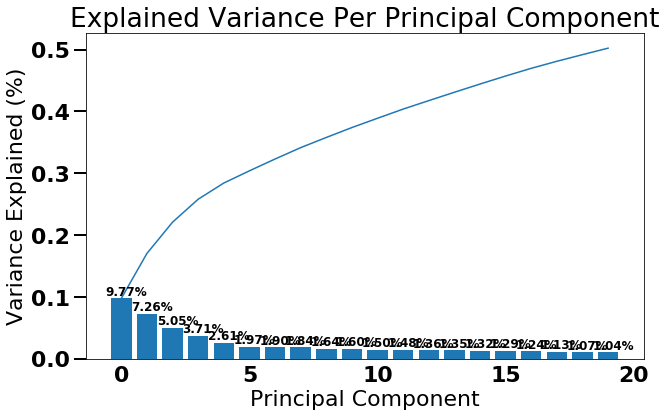

In [44]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)


,Explained Variance,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_STREAM,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
Dimension 1,0.0977,-0.0921,-0.1993,0.1235,-0.0920,0.0655,0.0575,0.1516,0.0279,-0.0148,...,-0.0697,-0.0103,0.0031,0.0339,0.0903,0.1114,-0.1133,0.0810,0.1821,-0.1087
Dimension 2,0.0727,0.2295,0.0761,-0.2211,0.2147,-0.1963,-0.2129,0.0953,-0.0502,0.1534,...,-0.0355,-0.0061,0.0133,0.0123,0.0394,0.0236,-0.0145,-0.2339,0.0635,0.0045
Dimension 3,0.0505,0.0279,0.1177,-0.0579,0.0520,-0.1489,-0.0543,-0.0467,-0.0031,0.0780,...,-0.0258,-0.0013,-0.0033,0.0022,0.0170,0.0259,0.0560,-0.0559,0.0291,-0.0180
Dimension 4,0.0371,-0.0273,-0.0106,0.0151,-0.0140,-0.0640,0.0626,-0.0156,-0.0076,-0.0035,...,-0.0399,0.0160,-0.0253,-0.0099,-0.0025,0.0005,0.3095,0.0308,-0.0398,0.0158
Dimension 5,0.0262,0.0424,0.0475,-0.0267,0.0154,0.0241,-0.1008,-0.0302,0.0032,0.0023,...,-0.0095,-0.0249,-0.0008,-0.0029,0.0430,0.0494,-0.1029,-0.0088,0.0757,-0.0348
Dimension 6,0.0198,0.0151,-0.1288,0.0062,0.0761,0.0101,0.0266,0.1861,-0.0704,0.0016,...,0.0171,0.0330,0.0447,0.0271,-0.0054,-0.0452,-0.0441,-0.0423,0.0095,0.0102
Dimension 7,0.0191,-0.0151,-0.0120,0.0040,-0.1149,0.0858,-0.0857,0.0877,-0.0477,-0.0537,...,-0.0425,0.0150,-0.0013,-0.0156,0.0040,-0.0278,0.0730,0.0129,-0.0318,0.0804
Dimension 8,0.0184,0.0150,0.0825,-0.0226,-0.0099,-0.0626,0.0182,-0.1668,0.0787,0.0347,...,0.0186,0.0527,-0.0570,0.0091,-0.0481,0.0133,-0.0688,0.0305,-0.0483,-0.0412
Dimension 9,0.0164,0.0253,-0.0023,-0.0424,0.0122,-0.0595,0.0114,0.0260,-0.1214,0.0129,...,-0.0245,0.0318,0.0265,0.0133,0.0044,-0.0560,-0.0305,-0.0297,-0.0109,0.0365
Dimension 10,0.0160,-0.0389,-0.0009,0.0026,0.0117,0.0010,0.0315,0.0344,-0.1688,-0.0273,...,-0.0000,-0.0270,-0.0378,-0.0182,-0.0034,0.0376,-0.0180,-0.0571,-0.0157,-0.0066


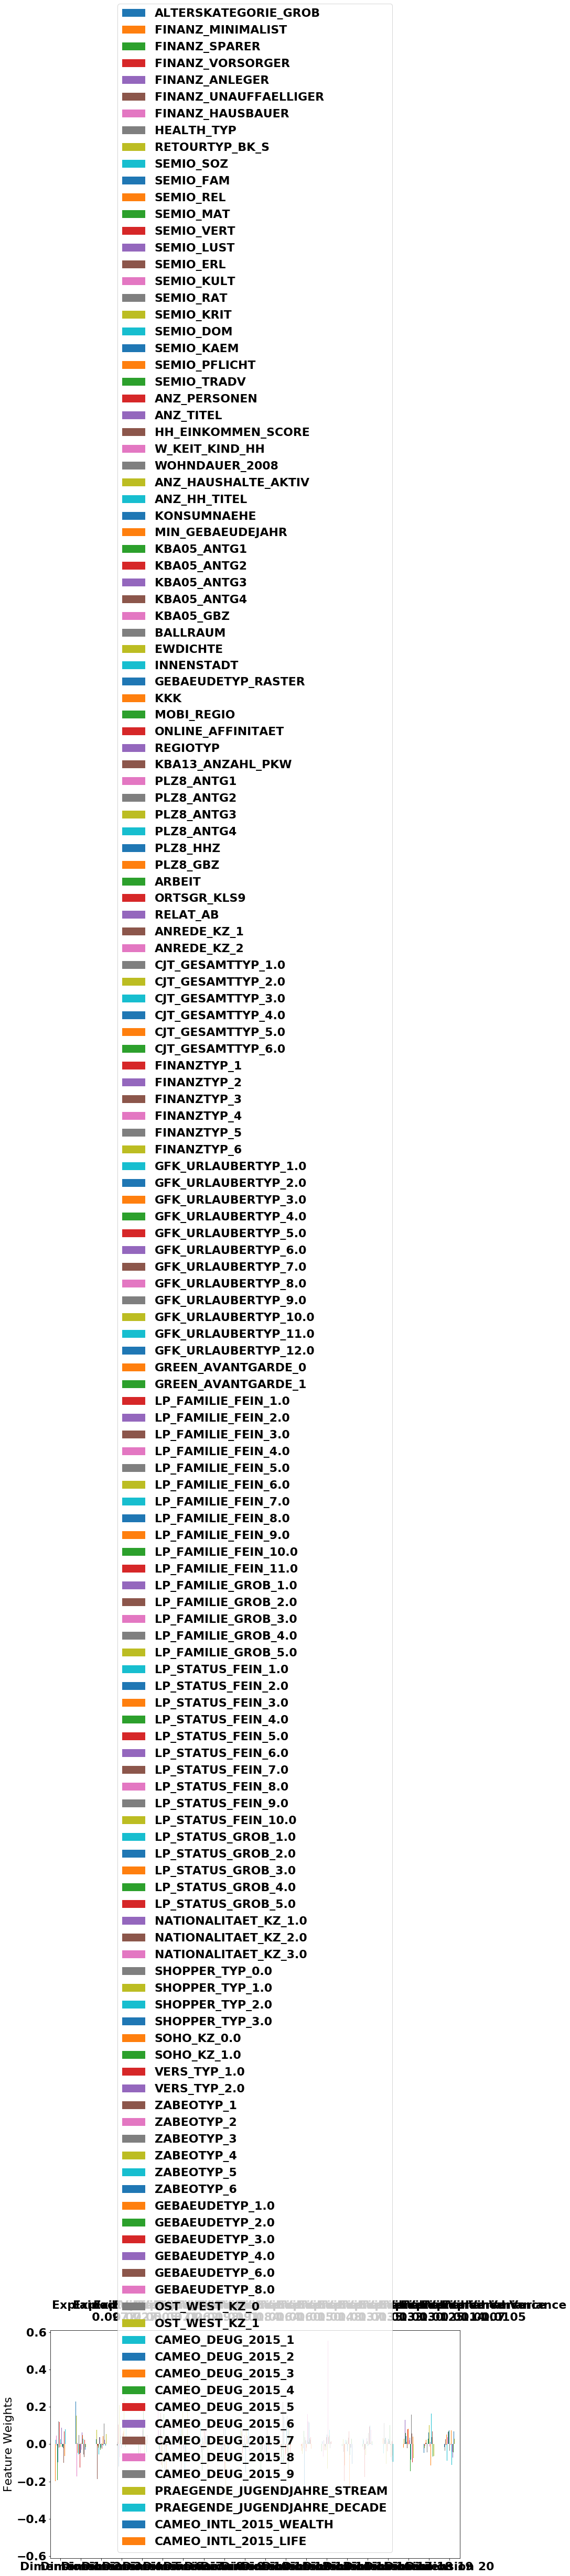

In [45]:
pca_results(azdias_normal, pca)

In [46]:
# Re-apply PCA to the data while selecting for number of components to retain.
for n in range(50,100):
    pca = PCA(n)
    azdias_normal_imp_scaled_reduced = pca.fit_transform(azdias_normal_imp_scaled)
    if pca.explained_variance_ratio_.sum() > 0.90:
        break
print(pca.explained_variance_ratio_.sum())
print(pca.n_components)

0.9030341888303762
77


In [47]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA(78)

azdias_normal_imp_scaled_reduced = pca.fit_transform(azdias_normal_imp_scaled)
print(pca.explained_variance_ratio_.sum())
print(pca.n_components)

0.9075311506276026
78


### Discussion 2.2: Perform Dimensionality Reduction
The number of principal components that explains 90% of the AZDIAS dataset variance has been determined as 78 components. With this number, the PCA model has been created for usage on the customers' dataset.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [48]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_components(Y, n, display_rows):
        num_feat = len(Y.columns)
#build data dictionary with key = 0,1,2,  values = column labels
        K = np.arange(num_feat)
        V = Y.columns.values.tolist()
        dd = dict(zip(K,V))
        pca = PCA(n_components=n)
        pca.fit(Y)
        for j in range(3):
                a = np.zeros(shape=(2,num_feat))
                a[0,:]  =np.arange(num_feat)
                a[1,:] = pca.components_[j,:]
                b = a[:,a[1].argsort()]
                ids = a[1].argsort()
                idsR = a[1].argsort()[::-1][:num_feat]
                c = a[:,idsR]
                d = c.T
#create  a dataframe out of array d
                component = pd.DataFrame(d, columns=['number', 'weight'])
                component['labels'] = component['number'].map(dd)
                component.drop(columns=['number'], inplace=True)
                print('top ',display_rows,' positive features for component#',j)
                print(component[0:display_rows])
                print(' ')
                print('top ',display_rows,' negative features for component#',j)
                print(component[num_feat-display_rows:num_feat+1])
                print(' ')
                print(' ')
                print(' ')


In [49]:
W = pd.DataFrame(azdias_normal_imp_scaled, columns=azdias_normal.columns)
pca_components(W,78, 8)

top  8  positive features for component# 0
     weight                  labels
0  0.199851      LP_STATUS_GROB_1.0
1  0.190162      HH_EINKOMMEN_SCORE
2  0.182114  CAMEO_INTL_2015_WEALTH
3  0.180486              PLZ8_ANTG3
4  0.175227              PLZ8_ANTG4
5  0.151734             ORTSGR_KLS9
6  0.151560        FINANZ_HAUSBAUER
7  0.150096                EWDICHTE
 
top  8  negative features for component# 0
       weight             labels
144 -0.125378         INNENSTADT
145 -0.133567           PLZ8_GBZ
146 -0.134215        KONSUMNAEHE
147 -0.181779         PLZ8_ANTG1
148 -0.182734          KBA05_GBZ
149 -0.193354        KBA05_ANTG1
150 -0.199295  FINANZ_MINIMALIST
151 -0.205536         MOBI_REGIO
 
 
 
top  8  positive features for component# 1
     weight                labels
0  0.229548  ALTERSKATEGORIE_GROB
1  0.214698      FINANZ_VORSORGER
2  0.201354            ZABEOTYP_3
3  0.185840             SEMIO_ERL
4  0.160800            SEMIO_LUST
5  0.153415        RETOURTYP_BK_S
6  0

In [50]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# JP: see above output

In [51]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# JP: see above output

### Discussion 2.3: Interpret Principal Components
Generally, it is difficult to use the principal components and related weights for a correlation with individual profiles. Having said that, some observations are: 
Component#0:
Positively affected by: low income, 6-10 family houses in the PLZ8 region, home owner, density of household
Negatively affected by: mobility, low financial interest, RR3 micro-cell, Distance from building to point of sale
Because 3 features related to income show up among the large positive weights, and one of them is LP_STATUS_GROB_1.0, I conclude that low income is an important feature. Another feature is related to the zip code (PLZ8*), where the negatives are related to ‘RR3 microcell’.
Component#1:
Age group plays a role, as well as financial attitude towards future safety and savings. Further, the weights of the SEMIO type features indicate that the behavioral aspects are important.



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [52]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [53]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)

    # Obtain a score related to the model fit
    score = np.abs(model.score(data))

    return score

scores = []
centers = list(range(1,11))


In [54]:
#azdias_normal_imp_scaled_reduced
scores = []
centers = list(range(1,21))

for center in centers:
    scores.append(get_kmeans_score(azdias_normal_imp_scaled_reduced, center))
X = zip(centers, scores)
for i in X:
        print(i)


(1, 109637371.7369813)
(2, 100603156.25628506)
(3, 96084310.61843605)
(4, 92878736.03590983)
(5, 90505003.31141037)
(6, 88747149.79158156)
(7, 87285479.91361646)
(8, 86082576.79443754)
(9, 85035144.89079893)
(10, 83964958.01862091)
(11, 83195708.19825289)
(12, 82191851.12657647)
(13, 81064311.58181551)
(14, 80168145.7821254)
(15, 79242631.97569136)
(16, 78385907.35862656)
(17, 78632481.2867549)
(18, 77587748.32401091)
(19, 77274765.69586934)
(20, 76381897.22209392)


Text(0.5, 1.0, 'score vs. number of clusters')

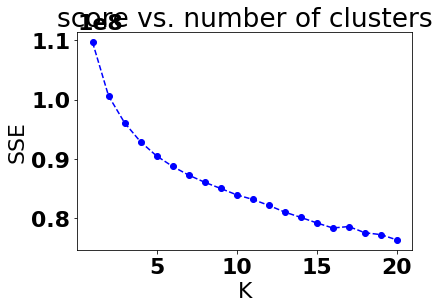

In [55]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('score vs. number of clusters')

In [56]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=20)
model = kmeans.fit(azdias_normal_imp_scaled_reduced)
score_20 = np.abs(model.score(azdias_normal_imp_scaled_reduced))
print('k-means score on the AZDIAS data for 20 centers =',score_20)

k-means score on the AZDIAS data for 20 centers = 75942766.45589036


### Discussion 3.1: Apply Clustering to General Population
This is a multi-variables, unsupervised learning use case: hence, the only viable method to ascertain the quality of the k-means analysis is the ‘elbow’ method. The aim is to determine the cluster size (or number of centers) at which the rate of decline of the average distances between points and cluster centers flattens out. In this case, even with 50 centers I do not see a real elbow. Consequently, I decided to just use 20 centers, delivering 18% less accuracy but with faster time to solution. 


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [57]:
# Load in the customer demographics data.
customers =  pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', sep =';')

In [58]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_normal = process_dataframe(customers)

customers_normal_imp = pd.DataFrame(imp.fit_transform(customers_normal))

 DATAFRAME contains  191652  records
 DATAFRAME contains  85  columns


C:\Users\joepareti54\anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\joepareti54\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Total execution time for converting unknown values to NaN  1.6786725521087646 seconds
col  0  col-label  AGER_TYP  number of NaN  96738  % of Nan  50.47586250078267
col  11  col-label  GEBURTSJAHR  number of NaN  93024  % of Nan  48.537975079832194
col  14  col-label  HEALTH_TYP  number of NaN  48990  % of Nan  25.561956045332163
col  15  col-label  LP_LEBENSPHASE_FEIN  number of NaN  51053  % of Nan  26.6383862417298
col  16  col-label  LP_LEBENSPHASE_GROB  number of NaN  50941  % of Nan  26.57994698724772
col  17  col-label  LP_FAMILIE_FEIN  number of NaN  50582  % of Nan  26.392628305470332
col  18  col-label  LP_FAMILIE_GROB  number of NaN  50582  % of Nan  26.392628305470332
col  21  col-label  NATIONALITAET_KZ  number of NaN  48750  % of Nan  25.436729071441988
col  22  col-label  PRAEGENDE_JUGENDJAHRE  number of NaN  48487  % of Nan  25.29950117922067
col  38  col-label  SHOPPER_TYP  number of NaN  48990  % of Nan  25.561956045332163
col  39  col-label  SOHO_KZ  number of NaN  4

C:\Users\joepareti54\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\joepareti54\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015']
feature  ANREDE_KZ  is binary 
feature  CJT_GESAMTTYP is multilevel=  6
feature  FINANZTYP is multilevel=  6
feature  GFK_URLAUBERTYP is multilevel=  12
feature  GREEN_AVANTGARDE  is binary 
feature  LP_FAMILIE_FEIN is multilevel=  11
feature  LP_FAMILIE_GROB is multilevel=  5
feature  LP_STATUS_FEIN is multilevel=  10
feature  LP_STATUS_GROB is multilevel=  5
feature  NATIONALITAET_KZ is multilevel=  3
feature  SHOPPER_TYP is multilevel=  4
feature  SOHO_KZ  is binary 
feature  VERS_TYP  is binary 
feature  ZABEOTYP is multilevel=  6
feature  GEBAEUDETYP is multilevel=  6
feature  OST_WEST_KZ  is binary 
feature  CAMEO_DEUG_2015 is multilevel=  9
exec time for 1-hot-encoding of categorical variables  3.03245377540

number of columns after all transformations  152
expected number of columns 152


In [59]:
A_COLUMNS = azdias_normal.columns.tolist()
C_COLUMNS = customers_normal.columns.tolist()
print(len(A_COLUMNS))
print('_________________')
print(len(C_COLUMNS))

152
_________________
152


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [60]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
customers_normal_imp_scaled = scaler.fit_transform(customers_normal_imp)
customers_normal_imp_scaled_reduced = pca.transform(customers_normal_imp_scaled)
predict_customers_dataset = model.predict(customers_normal_imp_scaled_reduced)
predict_azdias_dataset = model.predict(azdias_normal_imp_scaled_reduced)


proportion of k-means clusters for AZDIAS data
[0.09814265870819032, 0.04419395263163192, 0.059571560861206456, 0.06086749740812691, 0.03245880683247944, 0.04001927548339691, 0.031895137344110154, 0.11960110318171295, 0.07540211778679201, 0.008377034494559583, 0.014371055571772238, 0.06708547645170057, 0.023307984982234346, 0.03442158451519391, 0.06171048525903633, 0.011399208849610968, 0.010519733464856214, 0.04152910447010035, 0.07004851583810608, 0.09507770586518234]
proportion of k-means clusters for CUSTOMERS data
[0.06951269596249983, 0.04579185135881495, 0.04884369733618456, 0.022623312987693486, 0.03839944486142778, 0.06791950490702844, 0.007080849135428321, 0.036862900599039836, 0.1280146715194086, 0.009707844164672227, 0.005409768739467237, 0.22231742030504298, 0.019458173424157024, 0.04038208261934771, 0.07682013227026185, 0.016378004050245705, 0.005374364493790095, 0.029024400606120687, 0.033322476031325675, 0.07675640462804299]


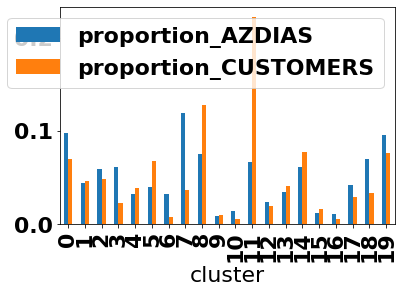

In [61]:
L_A = len(azdias_normal.index)
L_C = len(customers_normal.index)
x = [i for i in range (20)]
orig = []
NEW = []
for i in range(20):
    orig.append((predict_azdias_dataset== i).sum()/L_A)
    NEW.append((predict_customers_dataset== i).sum()/L_C)
print('proportion of k-means clusters for AZDIAS data')
print(orig)
print('proportion of k-means clusters for CUSTOMERS data')
print(NEW)

df_summary = pd.DataFrame({'cluster' : x, 'proportion_AZDIAS' : orig, 'proportion_CUSTOMERS': NEW})
df_summary.plot(x='cluster', y= ['proportion_AZDIAS','proportion_CUSTOMERS' ], kind='bar')



In [62]:


IPCA = pca.inverse_transform(model.cluster_centers_)
APPROX = scaler.inverse_transform(IPCA)
approx_df =pd.DataFrame(APPROX, columns=azdias_normal.columns)
print(approx_df)

    ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
0               3.993093           3.783505       0.984513          5.075823   
1               3.074633           4.904546       1.745450          3.893205   
2               4.004684           5.175908       0.791197          5.073034   
3               2.847280           3.262932       2.456754          3.659606   
4               3.606487           4.830015       1.243098          4.617156   
5               3.732356           4.591550       0.976877          4.961271   
6               2.667527           3.408287       2.397849          3.991107   
7               2.758661           2.821849       2.414857          3.815508   
8               3.864909           5.558921       0.835912          5.117759   
9               3.470183           4.299896       1.433302          4.558296   
10              3.168667           3.816150       1.882943          4.062861   
11              3.712850           5.508

In [63]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# process cluster#19
row_19 = approx_df.iloc[19,:].tolist()
labels = azdias_normal.columns.tolist()
z_19 = zip(labels, row_19)
for p in z_19:
    print(p)

('ALTERSKATEGORIE_GROB', 3.817495829265251)
('FINANZ_MINIMALIST', 4.2929789932827545)
('FINANZ_SPARER', 1.0382921220503252)
('FINANZ_VORSORGER', 5.046888241349939)
('FINANZ_ANLEGER', 0.792426312756374)
('FINANZ_UNAUFFAELLIGER', 1.1648297067236872)
('FINANZ_HAUSBAUER', 3.2084829423319827)
('HEALTH_TYP', 2.201336625103212)
('RETOURTYP_BK_S', 4.760697704012929)
('SEMIO_SOZ', 5.251916957097648)
('SEMIO_FAM', 4.871685788368141)
('SEMIO_REL', 3.1292256227708397)
('SEMIO_MAT', 3.745468219550699)
('SEMIO_VERT', 6.54723848632395)
('SEMIO_LUST', 5.924840001672449)
('SEMIO_ERL', 4.47168323799021)
('SEMIO_KULT', 4.81006541027692)
('SEMIO_RAT', 1.8729348904114376)
('SEMIO_KRIT', 3.1672339551639226)
('SEMIO_DOM', 3.0168269260495464)
('SEMIO_KAEM', 2.3187822759515244)
('SEMIO_PFLICHT', 2.492011550237078)
('SEMIO_TRADV', 2.278916054620294)
('ANZ_PERSONEN', 1.8491954460609812)
('ANZ_TITEL', 0.010194050265158749)
('HH_EINKOMMEN_SCORE', 4.493494766004651)
('W_KEIT_KIND_HH', 5.07226482659607)
('WOHNDAUER_

In [64]:
#interpretation of cluster #19:
# male
# approx 60 years old, german
# interested in financial matters, money saver, investor(see FINANZTYP)
# home owner
# mixed cell with low business share
# approx 40 KM away from urban center
# sanitary affine
# somehow, vacation attitude Connoisseur
# high affinity for online activity
# high purchase power in region
# conservative low returner (see RETOURTYP_BK_S score)
# rational, critical minded, combative, dutiful, somehow traditional
# 3 persons household
# high income, top earner
# average number of children
# resident more than 10 years
# wealthy, mature couple (see CAMEO_INTL_2015*)
# avantgarde, born in the 50's (see PRAEGENDE*STREAM and PRAEGENDE*DECADE)
# west germany (see the dummy variables OST_WEST_KZ_0 = 0.9949000413114113 and 
'OST_WEST_KZ_1' = 0.005099958688588729)
#small or home office
# avantguarde, also confirmed by dummy variables GREEN_AVANTGARDE_*


SyntaxError: invalid syntax (<ipython-input-64-4259d21e6f6f>, line 21)

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# process cluster#14
row_14 = approx_df.iloc[14,:].tolist()
labels = azdias_normal.columns.tolist()
z_14 = zip(labels, row_14)
for p in z_14:
    print(p)

In [ ]:
#interpretation of cluster #14:
# approx 45 years old, German, possibly female
# working class
# family shopper
# residential building
# unlikely home owner, otherwise average attitude towards finance matters
# sanitary affine
# normal returner
# average personality type, not dominant and not combative minded
# 2 persons household
# average to low wealth, household with children 
# mainstream orientation
# located in west Germany


### Discussion 3.3: Compare Customer Data to Demographics Data


#What kinds of people are part of a cluster that is overrepresented in the
#customer data compared to the general population.

male
approx 60 years old, german
interested in financial matters, money saver, investor(see FINANZTYP)
home owner
mixed cell with low business share
approx 40 KM away from urban center
sanitary affine
somehow, vacation attitude Connoisseur
high affinity for online activity
high purchase power in region
conservative low returner (see RETOURTYP_BK_S score)
rational, critical minded, combative, dutiful, somehow traditional
3 persons household
high income, top earner
average number of children
resident more than 10 years
wealthy, mature couple (see CAMEO_INTL_2015*)
avantgarde, born in the 50's (see PRAEGENDE*STREAM and PRAEGENDE*DECADE)
west germany (see the dummy variables OST_WEST_KZ_0 = 0.9949000413114113 and 
'OST_WEST_KZ_1' = 0.005099958688588729)
small or home office
avantguarde, also confirmed by dummy variables GREEN_AVANTGARDE_*

#What kinds of people are part of a cluster that is underrepresented in the
#customer data compared to the general population?

approx 45 years old, German, possibly female
working class
family shopper
residential building
unlikely home owner, otherwise average attitude towards finance matters
sanitary affine
normal returner
average personality type, not dominant and not combative minded
2 persons household
average to low wealth, household with children 
mainstream orientation
located in west Germany

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.